# face recognition pipeline

### 1. face detection
### 2. face encoding
### 3. face matching



### Requirements

In [2]:
!pip install opencv-python
!pip install mediapipe
!pip install keras-facenet




### Imports

In [3]:
import cv2
import mediapipe as mp
import numpy as np
import pickle
from PIL import Image as Img
from numpy import asarray, expand_dims
import matplotlib.pyplot as plt
from keras_facenet import FaceNet


### Global Variables

In [4]:
MyFaceNet = FaceNet()

### Logger

In [6]:
class FaceRecognitionLogger:
    def __init__(self, debug=False):
        self.debug = debug

    def log_step(self, message, show_separator=False):
        """Log a step message"""
        if self.debug:
            if show_separator:
                print("\n" + "=" * 50)
            print(message)

    def plot_images(self, images, titles=None, figsize=(15, 5)):
        """Plot one or more images"""
        if not self.debug:
            return

        if not isinstance(images, list):
            images = [images]
        if not titles:
            titles = [f"Image {i+1}" for i in range(len(images))]

        plt.figure(figsize=figsize)
        for i, image in enumerate(images):
            plt.subplot(1, len(images), i + 1)
            plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
            plt.title(titles[i])
            plt.axis("off")
        plt.show()

    def plot_face_detection(self, image, faces, title="Detected Faces"):
        """Plot image with detected face boxes"""
        if not self.debug:
            return

        debug_image = image.copy()
        for idx, face in enumerate(faces):
            x1, y1, width, height = face["box"]
            cv2.rectangle(
                debug_image, (x1, y1), (x1 + width, y1 + height), (0, 255, 0), 2
            )
            cv2.putText(
                debug_image,
                f"Face {idx+1} ({face['confidence']:.2f})",
                (x1, y1 - 10),
                cv2.FONT_HERSHEY_SIMPLEX,
                0.5,
                (0, 255, 0),
                2,
            )

        plt.figure(figsize=(10, 10))
        plt.imshow(cv2.cvtColor(debug_image, cv2.COLOR_BGR2RGB))
        plt.title(title)
        plt.axis("off")
        plt.show()

    def plot_face_crop(self, face_crop, index):
        """Plot a cropped face"""
        if not self.debug:
            return

        plt.figure(figsize=(5, 5))
        plt.imshow(face_crop)
        plt.title(f"Cropped Face {index+1}")
        plt.axis("off")
        plt.show()

    def log_comparison_result(self, face1_idx, face2_idx, similarity_score, threshold):
        """Log face comparison result"""
        if self.debug:
            print(f"Face {face1_idx+1} (Image 1) vs Face {face2_idx+1} (Image 2):")
            print(f"  Similarity Score: {similarity_score:.2f}%")
            print(f"  Match: {'✅' if similarity_score > threshold else '❌'}")

    def log_final_result(self, result):
        """Log final comparison result"""
        if self.debug:
            print("\n=== Final Results ===")
            print(f"Match Found: {'✅' if result['match'] else '❌'}")
            print(f"Best Match Score: {result['best_match_score']:.2f}%")
            print("=" * 50)

### Face Encoding

In [7]:
def encoding_generator(image, faces, logger=None):
    """Generate face encodings for detected faces"""
    if not faces:
        return []

    # Pre-convert image to RGB once
    rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Pre-allocate list for better memory efficiency
    encodings = [None] * len(faces)
    
    logger and logger.log_step(f"\nGenerating encodings for {len(faces)} faces...")

    # Process all faces in a single batch
    face_arrays = []
    for idx, face in enumerate(faces):
        # Extract face coordinates more efficiently
        box = face["box"]
        x1, y1 = abs(box[0]), abs(box[1])
        x2, y2 = x1 + box[2], y1 + box[3]

        # Crop face region
        face_crop = rgb_image[y1:y2, x1:x2]
        
        logger and logger.plot_face_crop(face_crop, idx)

        # Prepare face array more efficiently
        face_array = expand_dims(
            asarray(Img.fromarray(face_crop).resize((160, 160), reducing_gap=3.0)), 
            axis=0
        )
        face_arrays.append(face_array)

    # Generate encodings in batch
    face_arrays = np.vstack(face_arrays)
    batch_encodings = MyFaceNet.embeddings(face_arrays)

    # Store results
    for idx, encoding in enumerate(batch_encodings):
        logger and logger.log_step(f"Generated encoding for face {idx+1}, shape: {encoding.shape}")
        encodings[idx] = encoding

    return encodings

### Compare Faces in Pipeline

In [8]:
def compare_with_L2_distance(predefine_encoding, encoding):
    return np.linalg.norm(predefine_encoding - encoding) * 100 < 90

def compare_face(userid, call_userid, device_name):
    """
    Compare face encodings and handle both known and unknown persons in the image.
    Updates or adds encodings for both categories accordingly.
    """
    global user_data

    try:
        # Load the model data from the pickle file
        with open(user_data[userid]["modelfile"], "rb") as f:
            record = {}
            while True:
                try:
                    fulldata = pickle.load(f)
                    record_key = fulldata["names"] + "_" + str(fulldata["unique_id"])
                    record[record_key] = fulldata
                except EOFError:
                    break
    except FileNotFoundError:
        logger.error(f"Model file not found for user {userid}.")
        return {"known_faces": [], "unknown_faces": []}

    detected_faces = []
    unmatched_encodings = []
    matched_known_encodings = {}
    matched_unknown_encodings = {}

    # Compare each encoding
    for encoding in user_data[userid]["encodings"]:
        is_matched = False

        for record_key, fulldata in record.items():
            matches = [
                compare_with_L2_distance(predefine_encoding, encoding)
                for predefine_encoding in fulldata["encodings"]
            ]

            if any(matches):
                is_matched = True
                name = fulldata["names"]
                unique_id = str(fulldata["unique_id"])  # Ensure unique_id is a string
                detected_faces.append({"name": name, "unique_id": unique_id})

                # Store matched encoding for the corresponding record
                if name == "unknown":
                    if unique_id not in matched_unknown_encodings:
                        matched_unknown_encodings[unique_id] = []
                    matched_unknown_encodings[unique_id].append(encoding)
                else:
                    if name not in matched_known_encodings:
                        matched_known_encodings[name] = []
                    matched_known_encodings[name].append(encoding)
                break

        if not is_matched:
            unmatched_encodings.append(encoding)

    # Append matched encodings to their respective known or unknown objects
    for unique_id, encodings in matched_unknown_encodings.items():
        add_encoding_for_unknown_exist_person(
            userid, call_userid, device_name, unique_id, encodings
        )

    for name, encodings in matched_known_encodings.items():
        add_encoding_for_known_person(userid, call_userid, device_name, name, encodings)

    # Register new unknown faces for unmatched encodings
    if unmatched_encodings:
        user_data[userid][
            "encodings"
        ] = unmatched_encodings  # Temporarily store unmatched

        friend_ids, unique_ids = add_unknown(
            user_data[userid]["image"],
            user_data[userid]["modelfile"],
            "unknown",
            userid,
            call_userid,
            device_name,
        )
        for unique_id in unique_ids:
            detected_faces.append({"name": "unknown", "unique_id": str(unique_id)})

    # Collect and return detected face information
    unique_known_faces = {
        face["unique_id"] for face in detected_faces if face["name"] != "unknown"
    }
    unique_unknown_faces = {
        face["unique_id"] for face in detected_faces if face["name"] == "unknown"
    }

    print(f"Known faces: {unique_known_faces}")
    print(f"Unknown faces: {unique_unknown_faces}")

    # Logging results
    logger.info(
        f"Known faces detected: {unique_known_faces}",
        user_id=userid,
        session_id="",
        log_module="Face_Rec",
        call_userid=call_userid,
        device_name=device_name,
    )
    logger.info(
        f"Unknown faces detected: {unique_unknown_faces}",
        user_id=userid,
        session_id="",
        log_module="Face_Rec",
        call_userid=call_userid,
        device_name=device_name,
    )

    return {
        "known_faces": list(unique_known_faces),
        "unknown_faces": list(unique_unknown_faces),
    }

### Compare 2 faces

In [22]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

def compare_two_images(encodings1, encodings2, threshold=0.5, logger=None):
    """
    Compare faces between two images using cosine similarity and determine if they match.
    
    Args:
        encodings1: List of face encodings from the first image.
        encodings2: List of face encodings from the second image.
        threshold: Similarity threshold (0-1) for face matching (1 = identical, 0 = completely dissimilar).
        logger: Optional logger for debugging.
        
    Returns:
        dict: Contains match result, confidence scores, and best match score.
    """
    print("\n3. Comparing faces with cosine similarity...")

    # Ensure inputs are NumPy arrays for efficient computation
    encodings1 = np.array(encodings1)
    encodings2 = np.array(encodings2)

    # Compute cosine similarity matrix
    similarity_matrix = cosine_similarity(encodings1, encodings2)  # Shape: (len(encodings1), len(encodings2))

    # Determine matches based on the threshold
    matches = similarity_matrix > threshold

    # Compute best match scores for each encoding in encodings1
    best_match_scores = similarity_matrix.max(axis=1)

    # Check if any match exists
    overall_match = np.any(matches)

    # Log intermediate results if logger is provided
    if logger:
        logger.log_intermediate_results(
            match_matrix=matches,
            similarity_scores=similarity_matrix.tolist(),
        )

    # Compile results into a dictionary
    result = {
        "match": overall_match,
        "confidence_scores": best_match_scores.tolist(),
        "best_match_score": best_match_scores.max() if len(best_match_scores) > 0 else 0,
    }

    # Log the final result
    if logger:
        logger.log_final_result(result)

    return result


In [78]:
!pip show scikit-learn


Name: scikit-learn
Version: 1.3.2
Summary: A set of python modules for machine learning and data mining
Home-page: http://scikit-learn.org
Author: 
Author-email: 
License: new BSD
Location: c:\users\hp\miniconda3\envs\ml-gpu\lib\site-packages
Requires: joblib, numpy, scipy, threadpoolctl
Required-by: 


In [79]:
!pip show numpy scipy threadpoolctl joblib


Name: numpy
Version: 1.24.3
Summary: Fundamental package for array computing in Python
Home-page: https://www.numpy.org
Author: Travis E. Oliphant et al.
Author-email: 
License: BSD-3-Clause
Location: c:\users\hp\miniconda3\envs\ml-gpu\lib\site-packages
Requires: 
Required-by: cython_bbox, deep-sort-realtime, deepface, filterpy, h5py, imageio, jax, lap, matplotlib, mediapipe, mkl-fft, mkl-random, ml-dtypes, motmetrics, moviepy, onnx, onnxruntime, opencv-contrib-python, opencv-python, pandas, PyWavelets, retina-face, scikit-image, scikit-learn, scipy, seaborn, sinkhorn-knopp, tensorboard, tensorflow-intel, tifffile, torchvision, ultralytics, ultralytics-thop
---
Name: scipy
Version: 1.10.1
Summary: Fundamental algorithms for scientific computing in Python
Home-page: https://scipy.org/
Author: 
Author-email: 
License: Copyright (c) 2001-2002 Enthought, Inc. 2003-2022, SciPy Developers.
        All rights reserved.
        
        Redistribution and use in source and binary forms, with o

### Face Detection

In [12]:
# Updated functions using the logger
def mediapipe_detect_faces(image, logger, threshold=0):
    """Detects faces in an image using MediaPipe Face Detection."""
    mp_face_detection = mp.solutions.face_detection
    faces = []
    
    
    # Avoid redundant color conversion if image is already RGB
    if len(image.shape) == 3 and image.shape[2] == 3:
        rgb_image = image if image[0,0,0] <= image[0,0,2] else cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    else:
        rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Pre-calculate image dimensions
    h, w = image.shape[:2]

    with mp_face_detection.FaceDetection(
        model_selection=1, min_detection_confidence=threshold
    ) as face_detection:
        # plot image
        logger.plot_images([rgb_image], ["Sending to face detection"])
        results = face_detection.process(rgb_image)
        print("results", results)

        if results.detections:
            # Pre-allocate faces list with known size
            faces = [None] * len(results.detections)
            
            if logger is not None:
                logger.log_step(f"Found {len(results.detections)} faces")

            # Use enumerate to avoid manual indexing
            for i, detection in enumerate(results.detections):
                bboxC = detection.location_data.relative_bounding_box
                print("bboxC", bboxC)
                # Vectorized calculations
                faces[i] = {
                    "box": [
                        int(bboxC.xmin * w),
                        int(bboxC.ymin * h),
                        int(bboxC.width * w),
                        int(bboxC.height * h)
                    ],
                    "confidence": detection.score[0]
                }
        elif logger is not None:
            logger.log_step("No faces detected")

    if logger is not None:
        logger.plot_face_detection(image, faces)
    return faces

### Preprocessing


In [13]:
def brighten_image(image, alpha=1.5, beta=30):
    # Alpha controls contrast (1.0 is no change, higher is more contrast)
    # Beta controls brightness (0 is no change, positive values increase brightness)
    brightened_image = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)
    return brightened_image


def process_image(image, logger):
    if logger is not None:
        logger.log_step("Preprocessing image...")
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = brighten_image(image)
    if logger is not None:
        logger.plot_images([image], ["Processed Image"])
        logger.log_step("Image processed successfully")
    return image

### Pipeline

In [14]:
def pipeline(image_1, image_2, debug=False):
    logger = FaceRecognitionLogger(debug)
    # Face Detection
    faces_1 = mediapipe_detect_faces(image_1, logger)
    faces_2 = mediapipe_detect_faces(image_2, logger)
    
    print(faces_1)
    print(faces_2)

    # Preprocessing
    for faces, image in [(faces_1, image_1), (faces_2, image_2)]:
        if faces:
            image = process_image(image, logger)

    # Face Encoding
    encodings_1 = encoding_generator(image_1, faces_1, logger)
    encodings_2 = encoding_generator(image_2, faces_2, logger)
    
    # Compare Faces
    result = compare_two_images(encodings_1, encodings_2, logger=logger)
    print(result)
    return result

### Main

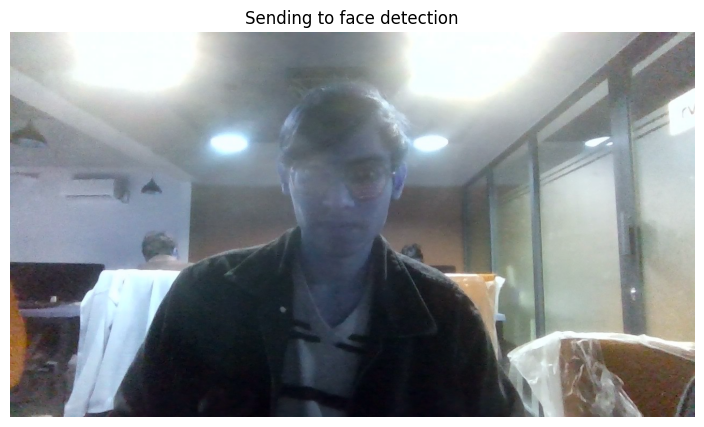

results <class 'mediapipe.python.solution_base.SolutionOutputs'>
Found 1 faces
bboxC xmin: 0.38758203387260437
ymin: 0.261560320854187
width: 0.1858251392841339
height: 0.3303689956665039



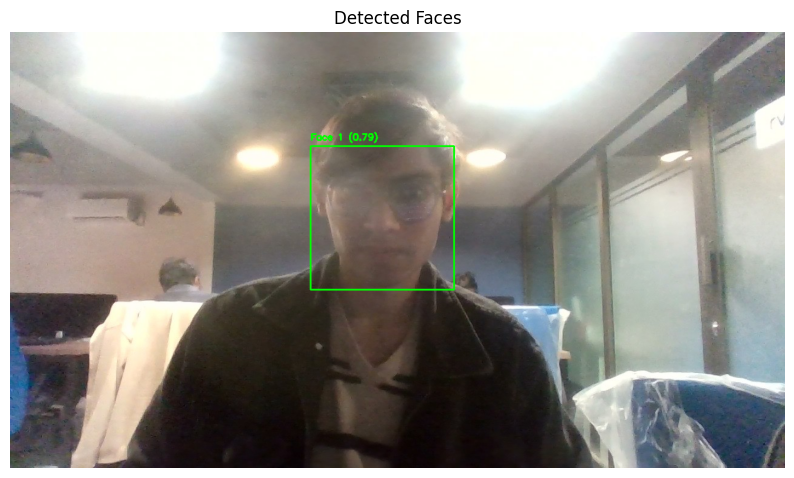

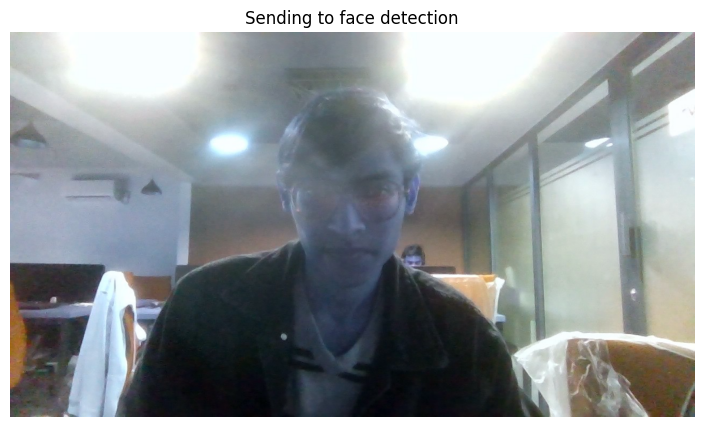

results <class 'mediapipe.python.solution_base.SolutionOutputs'>
Found 1 faces
bboxC xmin: 0.3841293156147003
ymin: 0.2939075231552124
width: 0.2008611261844635
height: 0.3570823073387146



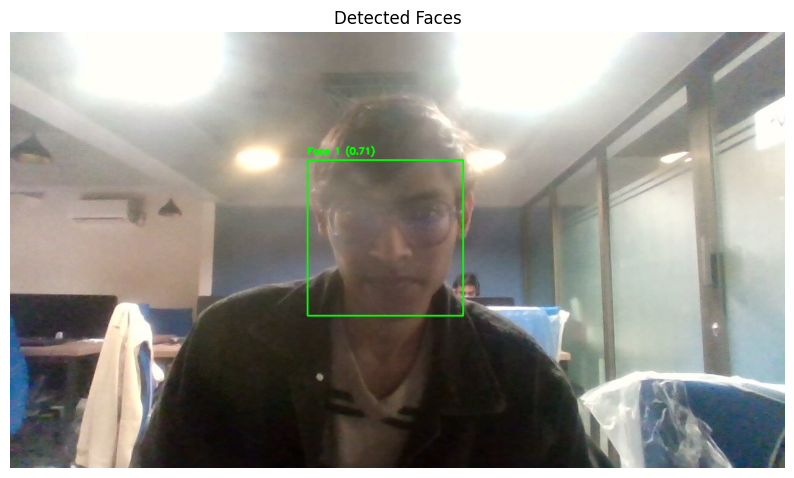

[{'box': [496, 188, 237, 237], 'confidence': 0.7942819595336914}]
[{'box': [491, 211, 257, 257], 'confidence': 0.711760938167572}]
Preprocessing image...


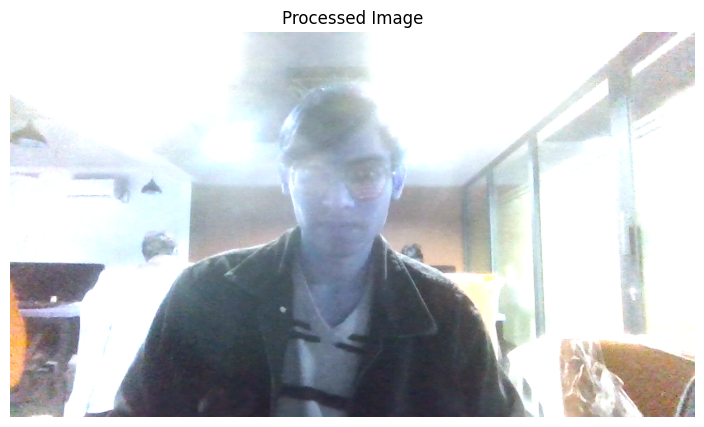

Image processed successfully
Preprocessing image...


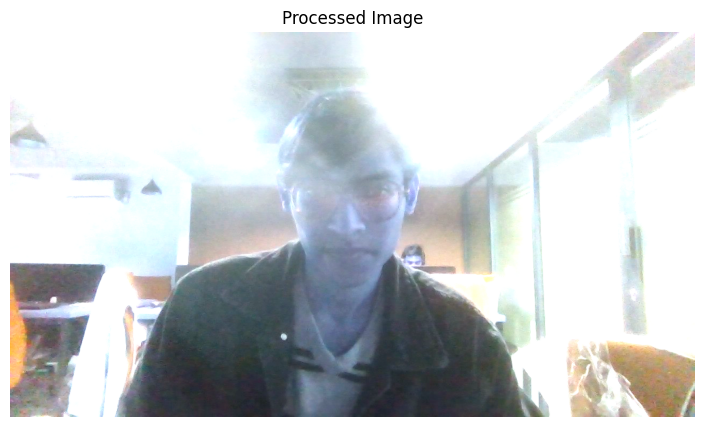

Image processed successfully

Generating encodings for 1 faces...


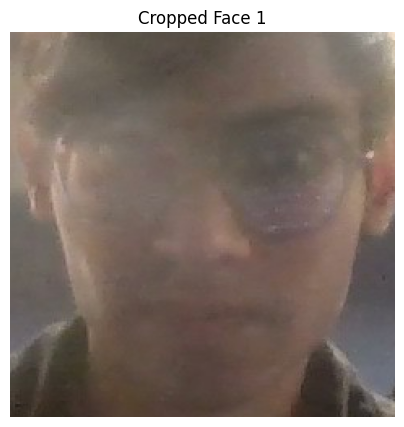

1/1 [==============================] - 1s 1s/step
Generated encoding for face 1, shape: (512,)

Generating encodings for 1 faces...


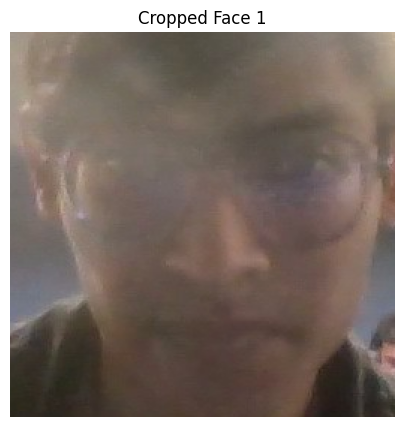

1/1 [==============================] - 0s 40ms/step
Generated encoding for face 1, shape: (512,)

3. Comparing faces with cosine similarity...


AttributeError: 'FaceRecognitionLogger' object has no attribute 'log_intermediate_results'

In [15]:
# Example usage:
image1 = cv2.imread(
    "C:/Users/Hp/Desktop/face_recognitionIrvineiAi/Person1.jpg"
)
image2 = cv2.imread(
    "C:/Users/Hp/Desktop/face_recognitionIrvineiAi/Person3.jpg"
)

# print(image2.type)
result = pipeline(image1, image2, debug=True)